In [3]:
import stim
print(stim.__version__)

1.12.0


In [4]:
circuit = stim.Circuit()
circuit.append("H", [0])
circuit.append("CNOT", [0,1])
circuit.append("M", [0,1])

In [5]:
circuit

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')

In [6]:
circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

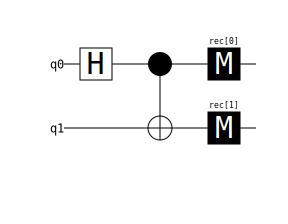

In [7]:
circuit.diagram('timeline-svg')

In [9]:
sampler = circuit.compile_sampler()

print(sampler.sample(shots=10))

[[ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO, WARNING messages are not printed

# uninstall sionna first
import sys
from pathlib import Path

sys.path.append(str(Path('..')))

from sionna.fec.ldpc import *
import time

GHP_n882_k24 = create_QC_GHP_codes(63, create_cyclic_permuting_matrix(7, [27,54,0]), [0,1,6]) # 18 <= d <= 24
my_code = GHP_n882_k24

In [14]:
from mqt.qecc import *

code = Code(my_code.hx, my_code.hz)
decoder = UFHeuristic()
decoder.set_code(code)

start_time = time.perf_counter()
num_err = 0
for i in range(1000):
    x_err = sample_iid_pauli_err(code.n, 0.05)
    decoder.decode(code.get_x_syndrome(x_err))
    result = decoder.result
    residual_err = np.array(x_err) ^ np.array(result.estimate)
    num_err += not code.is_x_stabilizer(residual_err)
end_time = time.perf_counter()
print("Elapsed time: ", end_time-start_time)
print("number of errors:", num_err)

Elapsed time:  7.833534591132775
number of errors: 1000


In [17]:
from ldpc import bposd_decoder
from bposd.css import css_code

code=css_code(hx=my_code.hx, hz=my_code.hz)
print(code.test())

bpd=bposd_decoder(
    code.hz,#the parity check matrix
    error_rate=0.05,
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=100, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0.8, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=0 #the osd search depth
    )

<Unnamed CSS code>, (3,6)-[[882,24,nan]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (3,6)-[[882,24,nan]]
True


In [19]:
start_time = time.perf_counter()
num_err = 0
for i in range(50000):
    err = np. random.uniform(size=882) < 0.05
    syndrome = code.hz @ err % 2
    bpd.decode(syndrome)
    residual_error=(bpd.osdw_decoding + err) %2
    a=(code.lz @ residual_error % 2).any()
    num_err += a
end_time = time.perf_counter()
print("Elapsed time: ", end_time-start_time)
print("number of errors:", num_err)

Elapsed time:  27.085997107904404
number of errors: 21
